# STAT3009 Project 2
# SID:1155152095(T = 2095)
# Name: Lam Wai Chiu

## Import package

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

from numpy.linalg import norm
from scipy.sparse import lil_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

import scipy as sp
from scipy.stats import chi2

## Load the existing methods

In [2]:
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_ratings):
		self.glb_mean = np.mean(train_ratings)
	
	def predict(self, test_pairs):
		pred = np.ones(len(test_pairs))
		pred = pred*self.glb_mean
		return pred

class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pairs, train_ratings):
		self.glb_mean = train_ratings.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pairs[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_ratings[ind_train].mean()
	
	def predict(self, test_pairs):
		pred = np.ones(len(test_pairs))*self.glb_mean
		j = 0
		for row in test_pairs:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pairs, train_ratings):
		self.glb_mean = train_ratings.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pairs[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_ratings[ind_train].mean()
	
	def predict(self, test_pairs):
		pred = np.ones(len(test_pairs))*self.glb_mean
		j = 0
		for row in test_pairs:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


class cor_rs_user(object):
	def __init__(self, n_user, n_item):
		self.n_user = n_user
		self.n_item = n_item
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
		self.S = lil_matrix((n_user, n_user))
		self.index_item = []
		self.index_user = []
		self.min_co = 3
	
	def cossim(self, index_u, index_v, train_pairs, train_ratings):
		item_u = train_pairs[index_u][:,1]
		item_v = train_pairs[index_v][:,1]
		# find co-rating items by `set`
		item_co = list(set(item_u).intersection(set(item_v)))
		if len(item_co) < self.min_co:
			# a tuning parameter
			return 0.0
		else:
			vec_u, vec_v = train_ratings[index_u], train_ratings[index_v]
			# find the co-rating vectors by using `np.isin`
			ind_co_u = [np.where(item_u == item_co_tmp)[0][0] for item_co_tmp in item_co]
			ind_co_v = [np.where(item_v == item_co_tmp)[0][0] for item_co_tmp in item_co]
			vec_co_u, vec_co_v = vec_u[ind_co_u], vec_v[ind_co_v]			
			return np.dot(vec_co_u, vec_co_v) / (norm(vec_co_u)+1e-5) / (norm(vec_co_v)+1e-5)
	
	def sim_mat(self, train_pairs, train_ratings):
		self.index_item = [np.where(train_pairs[:,1] == i)[0] for i in range(n_item)]
		self.index_user = [np.where(train_pairs[:,0] == u)[0] for u in range(n_user)]
		for u in range(self.n_user):
			for v in range(u):
				if (len(self.index_user[u]) == 0) or (len(self.index_user[v]) == 0):
					continue
				weight_tmp = self.cossim(self.index_user[u],self.index_user[v],train_pairs,train_ratings)
				if weight_tmp > 0:
					self.S[u,v] = weight_tmp
		self.S = self.S + self.S.T
	
	def fit(self, train_pairs, train_ratings):
		self.glb_mean = train_ratings.mean()
		# use another class to predict the user mean
		user_ave_method = user_mean(self.n_user)
		user_ave_method.fit(train_pairs, train_ratings)
		self.user_mean = user_ave_method.user_mean
		self.sim_mat(train_pairs, train_ratings)
	
	def predict(self, test_pairs, train_pairs, train_ratings, top=10):
		pred = np.zeros(len(test_pairs))
		for j in range(len(test_pairs)):
			user_tmp, item_tmp = test_pairs[j,0], test_pairs[j,1]
			index_tmp = self.index_item[item_tmp]
			rated_users = train_pairs[index_tmp][:,0]
			rated_ratings = train_ratings[index_tmp]
			sim_weight = self.S[user_tmp, rated_users].toarray()[0]
			## only keep top 10 closest users
			top_ind = sim_weight.argsort()[-top:][::-1]
			sim_weight_knn = np.zeros(len(sim_weight))
			sim_weight_knn[top_ind] = sim_weight[top_ind]
			if (len(rated_users) == 0) or (max(sim_weight_knn) == 0):
				# if no rated users or no similar users
				pred[j] = self.user_mean[user_tmp]
			else:
				pred[j] = np.sum(sim_weight_knn*rated_ratings) / np.sum(sim_weight_knn)
		return pred


class cor_rs_item(object):
	def __init__(self, n_user, n_item):
		self.n_user = n_user
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
		self.S = lil_matrix((n_item, n_item))
		self.index_item = []
		self.index_user = []
		self.min_co = 3

	def cossim(self, index_i, index_j, train_pairs, train_ratings):
		# index_u = np.where(train_pairs[:,0] == u)[0]
		# index_v = np.where(train_pairs[:,0] == v)[0]
		user_i = train_pairs[index_i][:,0]
		user_j = train_pairs[index_j][:,0]
		# find co-rating items by `set`
		user_co = list(set(user_i).intersection(set(user_j)))
		if len(user_co) < self.min_co:
			# a tuning parameter
			return 0.0
		else:
			# find the co-rating vectors by using `np.where`
			vec_i, vec_j = train_ratings[index_i], train_ratings[index_j]
			ind_co_i = [np.where(user_i == user_co_tmp)[0][0] for user_co_tmp in user_co]
			ind_co_j = [np.where(user_j == user_co_tmp)[0][0] for user_co_tmp in user_co]
			vec_co_i, vec_co_j = vec_i[ind_co_i], vec_j[ind_co_j]
			return np.dot(vec_co_i, vec_co_j) / (norm(vec_co_i)+1e-5) / (norm(vec_co_j)+1e-5)
	
	def sim_mat(self, train_pairs, train_ratings):
		self.index_item = [np.where(train_pairs[:,1] == i)[0] for i in range(n_item)]
		self.index_user = [np.where(train_pairs[:,0] == u)[0] for u in range(n_user)]
		for i in range(self.n_item):
			for j in range(i):
				if (len(self.index_item[i]) == 0) or (len(self.index_item[j]) == 0):
					continue
				weight_tmp = self.cossim(self.index_item[i],self.index_item[j],train_pairs,train_ratings)
				if weight_tmp > 0:
					self.S[i,j] = weight_tmp
		self.S = self.S + self.S.T
	
	def fit(self, train_pairs, train_ratings):
		self.glb_mean = train_ratings.mean()
		# use another class to predict the item mean
		item_ave_method = item_mean(self.n_item)
		item_ave_method.fit(train_pairs, train_ratings)
		self.item_mean = item_ave_method.item_mean
		self.sim_mat(train_pairs, train_ratings)
	
	def predict(self, test_pairs, train_pairs, train_ratings, top=10):
		pred = np.zeros(len(test_pairs))
		for j in range(len(test_pairs)):
			user_tmp, item_tmp = test_pairs[j,0], test_pairs[j,1]
			index_tmp = self.index_user[user_tmp]
			rated_items = train_pairs[index_tmp][:,1]
			rated_ratings = train_ratings[index_tmp]
			sim_weight = self.S[item_tmp, rated_items].toarray()[0]
			## only keep top 10 closest users
			top_ind = sim_weight.argsort()[-top:][::-1]
			sim_weight_knn = np.zeros(len(sim_weight))
			sim_weight_knn[top_ind] = sim_weight[top_ind]
			if (len(rated_items) == 0) or (max(sim_weight_knn) == 0):
				# if no rated items or no similar items
				pred[j] = self.item_mean[item_tmp]
			else:
				pred[j] = np.sum(sim_weight_knn*rated_ratings) / np.sum(sim_weight_knn)
		return pred

def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))


    

class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

In [5]:
def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = sp.linalg.inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

## Load the data

In [63]:
# Load dataset
item_feat = pd.read_csv("data/item_feats.csv")
user_feat = pd.read_csv("data/user_feats.csv")
test_pair = pd.read_csv("data/test_pair.csv")
train_rating = pd.read_csv("data/train_rating.csv")
sub = pd.read_csv('predict/sample_submission.csv')

## Feature engineering

In [64]:
# UserID,ItemID
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(np.append(train_rating['UserId'], test_pair["UserId"]), user_feat["UserId"]))

user_feat['UserId'] = le_user.transform(user_feat["UserId"])
test_pair["UserId"] = le_user.transform(test_pair["UserId"])
train_rating['UserId'] = le_user.transform(train_rating["UserId"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(np.append(train_rating['ItemId'], test_pair["ItemId"]), item_feat["ItemId"]))

item_feat['ItemId'] = le_item.transform(item_feat["ItemId"])
test_pair["ItemId"] = le_item.transform(test_pair["ItemId"])
train_rating['ItemId'] = le_item.transform(train_rating["ItemId"])

#Inf value
user_feat.loc[np.isinf(user_feat['V1']),'V1']=-3
item_feat.loc[np.isinf(item_feat['V2']),'V2']=2

# Missing data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(user_feat['V1'].values.reshape(-1, 1))
user_feat['V1'] = imp_mean.transform(user_feat['V1'].values.reshape(-1, 1))

## Generate some additional side information for users and items
- Number of ratings
- Averaged ratings
- quantiles of the ratings (as a practice)

### train dataset

In [65]:
# tran_pair, train_rating
train_pairs = train_rating[['UserId', 'ItemId']].values
train_ratings = train_rating['rating'].values
train_pair=train_rating.drop(columns='rating')
# test_pair
test_pairs = test_pair[['UserId', 'ItemId']].values
n_user, n_item = max(train_pairs[:,0].max(), test_pairs[:,0].max())+1, max(train_pairs[:,1].max(), test_pairs[:,1].max())+1


In [66]:
temp_train_user=np.zeros((len(train_pairs[:,0]), 4))
temp_train_item=np.zeros((len(train_pairs[:,0]), 3))

temp_test_user=np.zeros((len(test_pairs[:,0]), 4))
temp_test_item=np.zeros((len(test_pairs[:,0]), 3))

for i in range(0,len(train_pairs[:,0])):
    temp_train_user[i,:]=user_feat.loc[np.where(train_pairs[i,0]==user_feat.values[:,0])[0][0]].values[1:5]
    temp_train_item[i,:]=item_feat.loc[np.where(train_pairs[i,1]==item_feat.values[:,0])[0][0]].values[1:4]

for i in range(0,len(test_pairs[:,0])):
    temp_test_user[i,:]=user_feat.loc[np.where(test_pairs[i,0]==user_feat.values[:,0])[0][0]].values[1:5]
    temp_test_item[i,:]=item_feat.loc[np.where(test_pairs[i,1]==item_feat.values[:,0])[0][0]].values[1:4]


In [67]:
## baseline user mean methods
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pairs=train_pairs, train_ratings=train_ratings)
pred_user_mean = user_ave.predict(train_pairs)
user_mean_pred=pd.DataFrame({'user_mean':pred_user_mean})


In [68]:
## baseline item mean methods
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pairs=train_pairs, train_ratings=train_ratings)
pred_item_mean = item_ave.predict(train_pairs)
item_mean_pred=pd.DataFrame({'item_mean':pred_item_mean})


In [69]:
temp_train_user=pd.DataFrame(temp_train_user,columns=['V1','V2','V3','V4'])
temp_train_item=pd.DataFrame(temp_train_item,columns=['V1','V2','V3'])
temp_test_user=pd.DataFrame(temp_test_user,columns=['V1','V2','V3','V4'])
temp_test_item=pd.DataFrame(temp_test_item,columns=['V1','V2','V3'])

In [70]:
user_pd_train = pd.concat([temp_train_user, user_mean_pred], axis=1)
item_pd_train = pd.concat([temp_train_item, item_mean_pred], axis=1)

In [71]:
df=pd.DataFrame(np.column_stack((user_pd_train,item_pd_train,train_ratings)))
outlier, md=mahalanobis_method(df)

In [72]:
train_ratings=np.delete(train_ratings,[outlier], axis=0)
train_pairs=np.delete(train_pairs,[outlier], axis=0)
user_pd_train.drop(user_pd_train.index[outlier], inplace=True)
item_pd_train.drop(item_pd_train.index[outlier], inplace=True)
train_rating.drop(train_rating.index[outlier], inplace=True)
temp_train_user.drop(temp_train_user.index[outlier], inplace=True)
temp_train_item.drop(temp_train_item.index[outlier], inplace=True)

In [73]:
n_user, n_item = max(train_pairs[:,0].max(), test_pairs[:,0].max())+1, max(train_pairs[:,1].max(), test_pairs[:,1].max())+1

## Pre-processing the dataset
- all continuous features should be standardized as mean 0, std 1
- all categorical features should be re-encoding to remove the missing ones

In [75]:
## pre-processing for users
user_cont = ['user_mean','V1','V2','V3','V4']
user_pd_train[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_train[user_cont])

## pre-processing for items
item_cont = ['item_mean', 'V1','V2','V3']
item_pd_train[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_train[item_cont])


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_train.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_train.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
             V1        V2        V3        V4  user_mean
11832 -0.189418 -1.182123  1.151785  0.514892  -0.389708
13280  1.182700  0.511345  0.300006  0.514892  -1.421440
32057 -0.141241  0.406864  0.300006  0.514892  -0.053439
300   -0.141241 -1.730214  1.567343  0.514892   1.176997
25751 -0.141241 -0.218718 -0.857127  0.514892   0.346941
40308  1.176105  0.149143 -0.007644  0.514892  -0.324836
33598 -1.862547 -1.312724  0.100263  0.514892  -1.022242
7635  -0.779628  0.809117  1.627036  0.514892  -0.561069
706    0.415499  1.700691 -0.769883  0.514892  -0.534672
29667 -0.958484  0.208349  0.100263  0.514892  -0.861124
#######################################################
########## 10 random samples for items feats ##########
#######################################################
             V1        V2        V3  

### test dataset

In [76]:
## baseline user mean methods
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pairs=train_pairs, train_ratings=train_ratings)
pred_user_mean = user_ave.predict(test_pairs)
user_mean_pred=pd.DataFrame({'user_mean':pred_user_mean})

In [77]:
## baseline item mean methods
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pairs=train_pairs, train_ratings=train_ratings)
pred_item_mean = item_ave.predict(test_pairs)
item_mean_pred=pd.DataFrame({'item_mean':pred_item_mean})

In [78]:
user_pd_test = pd.concat([temp_test_user, user_mean_pred], axis=1)
item_pd_test = pd.concat([temp_test_item, item_mean_pred], axis=1)

## Pre-processing the dataset
                                                    - all continuous features should be standardized as mean 0, std 1
- all categorical features should be re-encoding to remove the missing ones

In [79]:
## pre-processing for users
user_cont = ['user_mean','V1','V2','V3','V4']
user_pd_test[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_test[user_cont])

## pre-processing for items
item_cont = ['item_mean', 'V1','V2','V3']
item_pd_test[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_test[item_cont])


print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_test.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_test.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
             V1        V2        V3        V4  user_mean
3789  -0.107994  0.473434 -0.012589  0.528364   0.767376
10624 -0.271714 -0.165903  1.306942  0.528364  -1.031655
8144  -0.107994  0.350367  0.202378 -0.708335   0.762435
11955  0.641502 -0.013597 -0.598032 -1.662060   3.250689
16983  0.685764  0.010842 -1.704883  0.528364  -0.648171
13456 -0.107994  0.350367  0.202378 -0.708335   0.762435
17986 -0.107994 -1.504364  0.543123  0.528364  -0.396883
4961  -0.107994  0.350367  0.202378 -0.708335   0.762435
14361 -0.107994 -1.333729  0.303000  0.528364  -1.293974
12798 -0.258383  1.770000 -1.720892  0.109144  -1.216247
#######################################################
########## 10 random samples for items feats ##########
#######################################################
             V1        V2        V3  

## Method 1: ``Regression``: rating ~ user_features + item_features

### Step 1: generate `joint_feats` by emerge all user and item features
- merge all continuous features

### joint_feats of train

In [80]:
train_joint_feats=np.concatenate((user_pd_train.values, item_pd_train), axis=1)

### joint_feats for testing data

In [81]:
test_joint_feats=np.concatenate((user_pd_test.values, item_pd_test.values), axis=1)

### Step 2: fit `regression`: rating ~ joint features


In [82]:
reg = LinearRegression().fit(train_joint_feats, train_ratings)
reg_rating = reg.predict(test_joint_feats)
train_rating_res = train_ratings - reg.predict(train_joint_feats)

### Step 3: fit ``LFM`` after the regression


3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.695, valid_rmse: 1.441
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.693, valid_rmse: 1.473
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.692, valid_rmse: 1.500
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.990, valid_rmse: 1.286
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.990, valid_rmse: 1.292
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.997, valid_rmse: 1.293
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.172, valid_rmse: 1.250
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.183, valid_rmse: 1.231
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.174, valid_rmse: 1.244
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 1.244, valid_rmse: 1.240
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 1.238, valid_rmse: 1.250
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 1.245, valid_rmse: 1.237
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 1.238, valid_rmse: 1.250
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 1.243, valid_rmse: 1.241
3-Fold

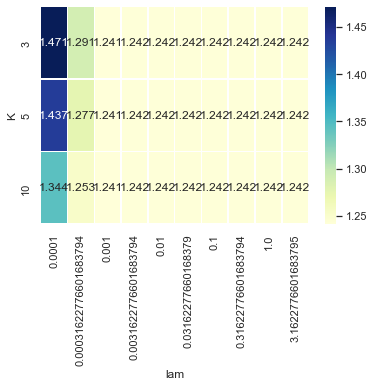

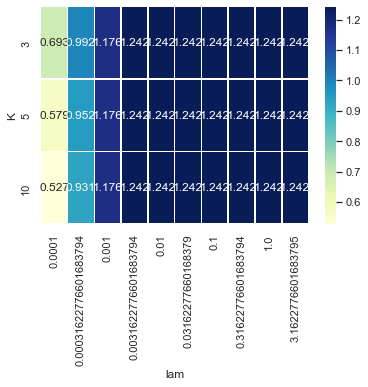

In [83]:
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [75]:
## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pairs, train_rating_res)
pred_LFM = reg_rating + shiing_best.predict(test_pairs)

K             3.000000
lam           0.001000
train_rmse    1.140729
valid_rmse    1.189146
Name: 2, dtype: float64
Fitting Reg-LFM: K: 3, lam: 0.00100
Reg-LFM: ite: 0; diff: 0.433 RMSE: 1.167
Reg-LFM: ite: 1; diff: 0.014 RMSE: 1.151
Reg-LFM: ite: 2; diff: 0.002 RMSE: 1.148
Reg-LFM: ite: 3; diff: 0.000 RMSE: 1.148


In [76]:
sub['rating'] = pred_LFM
sub.to_csv('predict/pred_reg_LMF.csv', index=False)

## Method 2: ``RandomForest Regressor``: rating ~ user_features + item_features

### Step 1: fit `regression`: rating ~ joint features


In [24]:
regressor = RandomForestRegressor(n_estimators = 500, random_state = 3009)
regressor.fit(train_joint_feats, train_ratings)
pred_reg=regressor.predict(test_joint_feats)
train_rating_res = train_ratings - reg.predict(train_joint_feats)

### Step 2: fit ``LFM`` after the RandomForest Regressor

3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.704, valid_rmse: 1.492
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.705, valid_rmse: 1.458
3-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.698, valid_rmse: 1.482
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.997, valid_rmse: 1.296
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.997, valid_rmse: 1.283
3-Fold CV for K: 3; lam: 0.00032: train_rmse: 0.991, valid_rmse: 1.296
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.177, valid_rmse: 1.244
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.177, valid_rmse: 1.242
3-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.178, valid_rmse: 1.237
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 1.239, valid_rmse: 1.246
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 1.246, valid_rmse: 1.232
3-Fold CV for K: 3; lam: 0.00316: train_rmse: 1.239, valid_rmse: 1.246
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 1.237, valid_rmse: 1.251
3-Fold CV for K: 3; lam: 0.01000: train_rmse: 1.248, valid_rmse: 1.227
3-Fold

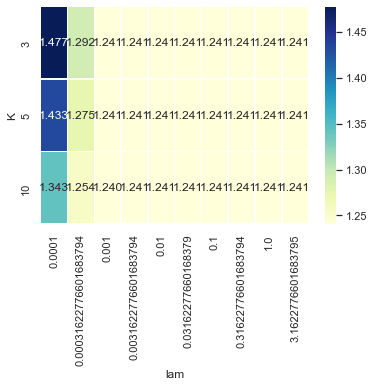

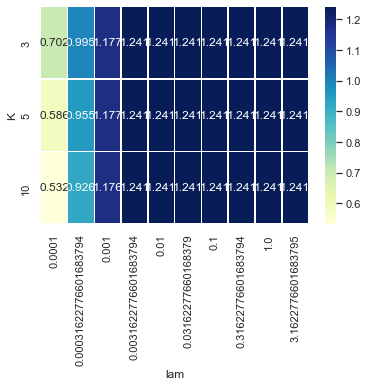

In [25]:
Ks, lams = [3, 5, 10], 10**np.arange(-4, 1, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=3, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pairs, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [84]:
## refit the best model with the full dataset
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing_best = LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing_best.fit(train_pairs, train_rating_res)
pred_LFM_rf = reg_rating + shiing_best.predict(test_pairs)

K             10.000000
lam            0.001000
train_rmse     1.175595
valid_rmse     1.241155
Name: 22, dtype: float64
Fitting Reg-LFM: K: 10, lam: 0.00100
Reg-LFM: ite: 0; diff: 0.653 RMSE: 1.184
Reg-LFM: ite: 1; diff: 0.001 RMSE: 1.185
Reg-LFM: ite: 2; diff: 0.002 RMSE: 1.186
Reg-LFM: ite: 3; diff: 0.001 RMSE: 1.187
Reg-LFM: ite: 4; diff: 0.000 RMSE: 1.187
Reg-LFM: ite: 5; diff: 0.000 RMSE: 1.187
Reg-LFM: ite: 6; diff: 0.000 RMSE: 1.188


In [85]:
sub['rating'] = pred_LFM_rf
sub.to_csv('predict/pred_mean_reg_LMF_rf_out.csv', index=False)

## Method 3: ``RandomForest Regressor``


In [86]:
regressor = RandomForestRegressor(n_estimators = 500, random_state = 3009)
regressor.fit(train_joint_feats, train_ratings)
pred_reg=regressor.predict(test_joint_feats)

In [87]:
sub['rating'] = pred_reg
sub.to_csv('predict/pred_mean_reg_rf_out.csv', index=False)

## Method 4: ``SLFM``

In [149]:
## CV based on `LFM_CV`

# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_ratings)
pred = glb_ave.predict(test_pairs)

# user_mean
train_rating_res = train_ratings - glb_ave.predict(train_pairs)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pairs=train_pairs, train_ratings=train_rating_res)
pred = pred + user_ave.predict(test_pairs)

# item_mean
train_rating_res -=  user_ave.predict(train_pairs)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pairs=train_pairs, train_ratings=train_rating_res)
pred = pred + item_ave.predict(test_pairs)

train_rating['res_rating'] = train_rating_res

In [155]:
from sklearn.preprocessing import StandardScaler
pd.DataFrame(temp_train_user)['UserId']= train_pairs[:,0]
pd.DataFrame(temp_train_item)['ItemId']= train_pairs[:,1]

user_info = pd.DataFrame({'UserId': list(range(n_user))})
user_info = user_info.set_index('UserId')
user_info['mean'] = train_rating.groupby('UserId')['res_rating'].mean()
user_info['q1'] = train_rating.groupby('UserId')['res_rating'].quantile(.1)
user_info['q3'] = train_rating.groupby('UserId')['res_rating'].quantile(.3)
user_info['q5'] = train_rating.groupby('UserId')['res_rating'].quantile(.5)
user_info['q7'] = train_rating.groupby('UserId')['res_rating'].quantile(.7)
user_info['q9'] = train_rating.groupby('UserId')['res_rating'].quantile(.9)
user_info['V1'] = temp_train_user.groupby('UserId')['V1'].mean()
user_info['V2'] = temp_train_user.groupby('UserId')['V2'].mean()
user_info['V3'] = temp_train_user.groupby('UserId')['V3'].mean()
user_info['V4'] = temp_train_user.groupby('UserId')['V4'].mean()
user_info['Frequency'] = temp_train_user.groupby('UserId').size()
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)


item_info = pd.DataFrame({'ItemId': list(range(n_item))})
item_info = item_info.set_index('ItemId')
item_info['mean'] = train_rating.groupby('ItemId')['res_rating'].mean()
item_info['q1'] = train_rating.groupby('ItemId')['res_rating'].quantile(.1)
item_info['q3'] = train_rating.groupby('ItemId')['res_rating'].quantile(.3)
item_info['q5'] = train_rating.groupby('ItemId')['res_rating'].quantile(.5)
item_info['q7'] = train_rating.groupby('ItemId')['res_rating'].quantile(.7)
item_info['q9'] = train_rating.groupby('ItemId')['res_rating'].quantile(.9)
item_info['V1'] = temp_train_item.groupby('ItemId')['V1'].mean()
item_info['V2'] = temp_train_item.groupby('ItemId')['V2'].mean()
item_info['V3'] = temp_train_item.groupby('ItemId')['V3'].mean()
item_info['Frequency'] = temp_train_item.groupby('ItemId').size()
## fill NAN as the column mean
item_info = item_info.fillna(item_info.mean())
item_scaler = StandardScaler()
item_info = item_scaler.fit_transform(item_info)

In [151]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(user_info)
item_sim = cosine_similarity(item_info)

In [152]:
top = 5
index_item = [np.where(train_pairs[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pairs[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_item_tmp = train_pairs[valid_user_ind,1]
	for i in range(n_item):
		top_item_tmp = item_sim[i].argsort()[-top:][::-1]
		valid_item_tmp = np.intersect1d(top_item_tmp, obs_item_tmp)
		if len(valid_item_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_item_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2


KeyboardInterrupt: 

In [ ]:
aug_pair, aug_rating_res = np.vstack((train_pairs, fake_pair)), np.hstack((train_rating_res, fake_rating))

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']

sSVD=LFM(n_user, n_item, K=best_K, lam=best_lam)
sSVD.fit(aug_pair, aug_rating_res)
pred = pred + sSVD.predict(test_pairs)
pred_rating = pred

In [ ]:
sub['rating'] = pred_LFM
sub.to_csv('predict/pred_GLB_user_item_sLMF_mqf_out.csv', index=False)

## Method 2: ``NCF`` Model based on side information

### Step 1: Formulate neural network based on continuous and categorical features
- embedding for categorical features
- concatenate continuous features and all embedding vectors

In [ ]:
class SideNCF(keras.Model):
    def __init__(self, num_users, num_movies, num_genre, embedding_size, **kwargs):
        super(SideNCF, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.genre_embedding = layers.Embedding(
            num_genre,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-2),
        )
        self.concatenate = layers.Concatenate()
        self.dense1 = layers.Dense(100, name='fc-1', activation='relu')
        self.dense2 = layers.Dense(50, name='fc-2', activation='relu')
        self.dense3 = layers.Dense(1, name='fc-3', activation='relu')

    def call(self, inputs):
        cont_feats = inputs[0]
        cate_feats = inputs[1]
        user_vector = self.user_embedding(cate_feats[:,0])
        movie_vector = self.movie_embedding(cate_feats[:,1])
        genre_vector = self.genre_embedding(cate_feats[:,2])
        concatted_vec = self.concatenate([cont_feats, user_vector, movie_vector, genre_vector])
        fc_1 = self.dense1(concatted_vec)
        fc_2 = self.dense2(fc_1)
        fc_3 = self.dense3(fc_2)
        return fc_3

In [ ]:
num_genre = movies_pd['pGenre'].max() + 1
model = SideNCF(num_users=n_user, num_movies=n_item, num_genre=num_genre, embedding_size=50)

metrics = [
    keras.metrics.MeanAbsoluteError(name='mae'),
    keras.metrics.RootMeanSquaredError(name='rmse')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss=tf.keras.losses.MeanSquaredError(), 
    metrics=metrics
)

# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

In [52]:
# tran_pair, train_rating
train_pairs = train_rating[['UserId', 'ItemId']].values
train_ratings = train_rating['rating'].values
# test_pair
test_pairs = test_pair[['UserId', 'ItemId']].values
n_user, n_item = max(train_pairs[:,0].max(), test_pairs[:,0].max())+1, max(train_pairs[:,1].max(), test_pairs[:,1].max())+1

# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pairs, train_ratings=train_ratings)
pred_user_mean = user_ave.predict(test_pairs)

## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pairs, train_ratings=train_ratings)
pred_item_mean = item_ave.predict(test_pairs)

user_rating=pd.concat([test_pair,pd.DataFrame({'rating':pred_user_mean})],axis=1)
item_rating=pd.concat([test_pair,pd.DataFrame({'rating':pred_item_mean})],axis=1)


In [53]:
## generate cont feats for users
user_pd_test = pd.merge(left=user_rating.groupby('UserId')['rating'].mean(), 
                        right=user_rating.groupby('UserId')['rating'].count(), on='UserId', )
user_pd_test = pd.merge(left=user_pd_test, 
                        right=user_rating.groupby('UserId')['rating'].quantile([0.1]), on='UserId', )
user_pd_test = pd.merge(left=user_pd_test, 
                        right=user_rating.groupby('UserId')['rating'].quantile([0.9]), on='UserId', )

user_pd_test.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
user_pd_test = user_pd_test.reset_index()

user_pd_test = pd.merge(left=user_pd_test, right=user_feat, on='UserId')

## generate cont feats for items
item_rating_pd_test = pd.merge(left=item_rating.groupby('ItemId')['rating'].mean(), 
                            right=item_rating.groupby('ItemId')['rating'].count(), on='ItemId')
item_rating_pd_test = pd.merge(left=item_rating_pd_test, 
                        right=item_rating.groupby('ItemId')['rating'].quantile([0.1]), on='ItemId', )
item_rating_pd_test = pd.merge(left=item_rating_pd_test, 
                        right=item_rating.groupby('ItemId')['rating'].quantile([0.9]), on='ItemId', )
item_rating_pd_test.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
item_rating_pd_test = item_rating_pd_test.reset_index()

item_pd_test = pd.merge(left=item_rating_pd_test, right=item_feat, on='ItemId')
print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')

print(user_pd_test.sample(10))
print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')

print(item_pd_test.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
      UserId  rating_mean  rating_count  quantile_0.1  quantile_0.9        V1  \
2125   15374     0.875000             1      0.875000      0.875000  3.604344   
1222    8900     1.640200             1      1.640200      1.640200  3.870928   
413     2955     2.714286             3      2.714286      2.714286  3.423729   
164     1162     1.640200             1      1.640200      1.640200  3.423729   
1310    9535     1.333333             1      1.333333      1.333333  2.768854   
178     1238     1.640200             1      1.640200      1.640200  3.855488   
569     4223     1.640200             2      1.640200      1.640200  3.423729   
2107   15272     1.640200             1      1.640200      1.640200  3.752474   
2348   16897     1.640200             1      1.640200      1.640200  3.423729   
1090    7924     4.000

In [12]:
## pre-processing for users
user_cont = ['rating_mean', 'rating_count', 'quantile_0.1','quantile_0.9', 'V1','V2','V3','V4']
user_pd_test[user_cont] = preprocessing.StandardScaler().fit_transform(user_pd_test[user_cont])

## pre-processing for items
item_cont = ['rating_mean', 'rating_count', 'quantile_0.1','quantile_0.9', 'V1','V2','V3']
item_pd_test[item_cont] = preprocessing.StandardScaler().fit_transform(item_pd_test[item_cont])



print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')
print(user_pd_test.sample(10))

print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')
print(item_pd_test.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
      UserId  rating_mean  rating_count  quantile_0.1  quantile_0.9        V1  \
655     4851     0.436174     -0.006685      0.436174      0.436174 -0.033176   
3673   25978    -0.853177      0.723905     -0.853177     -0.853177  0.243328   
3068   21735    -0.216675     -0.145845     -0.216675     -0.216675 -1.053768   
1511   10846     0.470777     -0.041475      0.470777      0.470777 -0.033176   
525     3926    -0.920253     -0.145845     -0.920253     -0.920253 -0.231115   
3092   21892    -1.228356      0.271635     -1.228356     -1.228356 -0.155004   
1195    8690    -0.216675     -0.145845     -0.216675     -0.216675 -0.033176   
1319    9576    -0.216675     -0.145845     -0.216675     -0.216675 -0.033176   
303     2062    -0.665923     -0.076265     -0.665923     -0.665923 -0.969943   
874     6501     0.097

In [13]:
# joint_feats of test
user_pd_test=user_pd_test.values
item_pd_test=item_pd_test.values

In [15]:
temp_user=np.zeros((len(test_pairs), len(user_pd_test[0,:])-1))
for i in range(len(test_pairs)):
    index=np.where(test_pairs[i,0]==user_pd_test[:,0])[0]
    temp_user[i,:]=user_pd_test[index,1:len(user_pd_test[0,:])]
    
temp_item=np.zeros((len(test_pairs), len(item_pd_test[0,:])-1))
for i in range(len(test_pairs)):
    index=np.where(test_pairs[i,1]==item_pd_test[:,0])[0]
    temp_item[i,:]=item_pd_test[index,1:len(item_pd_test[0,:])]

test_joint_feats=np.concatenate((temp_user, temp_item), axis=1)

In [51]:
temp_user=np.zeros((len(train_pairs), len(user_pd[0,:])-1))
for i in range(len(train_pairs)):
    index=np.where(train_pairs[i,0]==user_pd[:,0])[0]
    temp_user[i,:]=user_pd[index,1:len(user_pd[0,:])]
    
temp_item=np.zeros((len(train_pairs), len(item_pd[0,:])-1))
for i in range(len(train_pairs)):
    index=np.where(train_pairs[i,1]==item_pd[:,0])[0]
    temp_item[i,:]=item_pd[index,1:len(item_pd[0,:])]

train_joint_feats=np.concatenate((temp_user, temp_item), axis=1)

In [42]:
## generate cont feats for users

user_pd= pd.concat([train_rating, GLB_mean_pred, user_mean_pred,item_mean_pred,cor_user_pred,cor_item_pred], axis=1)



user_pd = pd.merge(left=GLB_mean_pred.groupby('UserId')['rating'], 
                        right=train_rating.groupby('UserId')['rating'].count(), on='UserId', )
user_pd = pd.merge(left=user_pd, 
                        right=train_rating.groupby('UserId')['rating'].quantile([0.1]), on='UserId', )
user_pd = pd.merge(left=user_pd, 
                        right=train_rating.groupby('UserId')['rating'].quantile([0.9]), on='UserId', )

user_pd.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
user_pd = user_pd.reset_index()

user_pd = pd.merge(left=user_pd, right=user_feat, on='UserId')

## generate cont feats for items
item_rating_pd = pd.merge(left=train_rating.groupby('ItemId')['rating'].mean(), 
                            right=train_rating.groupby('ItemId')['rating'].count(), on='ItemId')
item_rating_pd = pd.merge(left=item_rating_pd, 
                        right=train_rating.groupby('ItemId')['rating'].quantile([0.1]), on='ItemId', )
item_rating_pd = pd.merge(left=item_rating_pd, 
                        right=train_rating.groupby('ItemId')['rating'].quantile([0.9]), on='ItemId', )
item_rating_pd.columns = ['rating_mean', 'rating_count','quantile_0.1','quantile_0.9']
item_rating_pd = item_rating_pd.reset_index()

item_pd = pd.merge(left=item_rating_pd, right=item_feat, on='ItemId')
print('#######################################################')
print('########## 10 random samples for users feats ##########')
print('#######################################################')

print(user_pd.sample(10))
print('#######################################################')
print('########## 10 random samples for items feats ##########')
print('#######################################################')

print(item_pd.sample(10))

#######################################################
########## 10 random samples for users feats ##########
#######################################################
      UserId  rating_mean  rating_count  quantile_0.1  quantile_0.9        V1  \
2530   11780     4.000000             1           4.0          4.00  3.919329   
973     4533     5.000000             1           5.0          5.00  2.934012   
680     3199     3.500000             1           3.5          3.50  3.423729   
219      996     1.392857            14           0.0          3.85  3.423729   
2994   14043     0.000000             1           0.0          0.00  2.835416   
2365   10980     1.500000             1           1.5          1.50  4.000485   
356     1657     0.000000             1           0.0          0.00  3.303097   
3041   14302     0.000000             1           0.0          0.00  3.549563   
152      696     4.000000             1           4.0          4.00  3.953528   
2639   12348     4.500